# Personalized PageRank Graph Visualization

In [1]:
from matplotlib.animation import FuncAnimation
import gzip
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import shutil
import urllib.request

### Dataset Filenames

In [4]:
filenames = [
    'higgs-retweet_network.edgelist',
    'higgs-reply_network.edgelist',
    'higgs-mention_network.edgelist'
]

### Retrieve Dataset if Not Present in Directory

In [5]:
ROOT = 'https://snap.stanford.edu/data'

for filename in filenames:
    if not os.path.exists(filename):
        # Download .gz file
        urllib.request.urlretrieve(f'{ROOT}/{filename}.gz', f'{filename}.gz')

        # Extract .edgelist file from .gz file
        with gzip.open(f'{filename}.gz') as gzip_file:
            with open(filename, 'wb') as edgelist_file:
                shutil.copyfileobj(gzip_file, edgelist_file)
        
        # Remove .gz file
        os.remove(f'{filename}.gz')

### Personalized PageRank Algorithm

In [6]:
def personalized_pagerank(G, input_node, beta=0.85, tolerance=1e-6, max_iter=1000):
    N = len(G.nodes)
    
    # Assign numeric node_id to each node
    node_ids = dict(zip(G.nodes, np.arange(0, N)))
    nx.set_node_attributes(G, node_ids, 'node_id')

    # Generate personalization vector based on input node
    personalization_vec = np.zeros(N)
    personalization_vec[G.nodes[input_node]['node_id']] = 1

    # Transition matrix
    tsn_mx = np.zeros(shape=(N, N))
    for edge in G.edges():
        u = G.nodes[edge[0]]['node_id']
        v = G.nodes[edge[1]]['node_id']
        tsn_mx[v, u] = 1 / np.where(G.out_degree(edge[0]) > 0, G.out_degree(edge[0]), 1)

    # Handling dangling nodes
    row_sum = tsn_mx.sum(axis=0)
    dangling_weights = personalization_vec
    is_dangling = np.where(row_sum == 0)[0]

    # PageRank vector, prev_pr to keep track of previous value to test convergence
    pr = np.ones(N)
    prev_pr = np.zeros(N)

    # Iterate PageRank calculation until convergence
    i = 0
    yield G.nodes, pr, i, input_node
    yield G.nodes, pr, i, input_node
    while ~np.all(np.abs(pr - prev_pr) < tolerance) and i<=max_iter:
        prev_pr = pr
        pr = beta * (np.matmul(tsn_mx, pr) + sum(pr[is_dangling]) * dangling_weights) + (1 - beta) * personalization_vec
        pr /= np.linalg.norm(pr, ord=1)
        i += 1

        yield G.nodes, pr, i, input_node

    # Set PageRank values as node attributes
    pagerank = dict(zip(G.nodes, pr))
    nx.set_node_attributes(G, pagerank, 'pagerank')

    # Print top 20 recommendations
    print(sorted(G.nodes, key=lambda n: G.nodes[n]['pagerank'], reverse=True)[:20])
    
    # Print pagerank values of top 20 recommendations
    recs = sorted(G.nodes, key=lambda n: G.nodes[n]['pagerank'], reverse=True)[:20]
    print([G.nodes[n]['pagerank'] for n in recs])
    return pr

### Twitter Dataset

In [7]:
# Retrieve edges from dataset
G = nx.DiGraph()

for filename in filenames:
    with open(filename, 'r') as f:
        G.add_edges_from([tuple(edge.split(' ')[:2]) for edge in f.readlines()])

personalized_pagerank(G, '20120')

<generator object personalized_pagerank at 0x7f6a782fc040>

### Test on Smaller Graph

In [8]:
edges = [
    (1, 2),
    (2, 1),
    (1, 3),
    (3, 1),
    (2, 4),
    (4, 3),
    (1, 4),
    (2, 3),
    (4, 5),
    (1, 5),
    (3, 5),
    (6, 1),
    (3, 6),
    (6, 7),
    (6, 8),
    (6, 1),
    (4, 8),
    (5, 8),
    (7, 3)
]

# Compare PageRank values with NetworkX
G = nx.DiGraph()
G.add_edges_from(edges)
print(list(personalized_pagerank(G, 3)))
nx.pagerank(G, alpha=0.85, personalization={1: 0, 2: 0, 3: 1, 4: 0, 5: 0})

[3, 8, 5, 1, 6, 4, 2, 7]
[0.3597131741583607, 0.1605403043024198, 0.1422470673605033, 0.1391750742170353, 0.10191870248020868, 0.03795417341912678, 0.029574652872322853, 0.02887685119002267]
[(NodeView((1, 2, 3, 4, 5, 6, 7, 8)), array([1., 1., 1., 1., 1., 1., 1., 1.]), 0, 3), (NodeView((1, 2, 3, 4, 5, 6, 7, 8)), array([1., 1., 1., 1., 1., 1., 1., 1.]), 0, 3), (NodeView((1, 2, 3, 4, 5, 6, 7, 8)), array([0.12230216, 0.03057554, 0.37829736, 0.07134293, 0.11211031,
       0.04076739, 0.04076739, 0.20383693]), 1, 3), (NodeView((1, 2, 3, 4, 5, 6, 7, 8)), array([0.12739808, 0.02598921, 0.41277978, 0.03465228, 0.15338729,
       0.10718425, 0.01155076, 0.12705835]), 2, 3), (NodeView((1, 2, 3, 4, 5, 6, 7, 8)), array([0.15468675, 0.02707209, 0.31207159, 0.0344357 , 0.15384451,
       0.11695427, 0.03036887, 0.17056621]), 3, 3), (NodeView((1, 2, 3, 4, 5, 6, 7, 8)), array([0.12922775, 0.03287093, 0.37109297, 0.04054136, 0.131048  ,
       0.08842028, 0.03313704, 0.17366166]), 4, 3), (NodeView((1, 

{1: 0.13917533276657815,
 2: 0.029574794432214193,
 3: 0.3597113076641808,
 4: 0.03795422143004194,
 5: 0.1422471692390428,
 6: 0.10191874208140392,
 7: 0.028877163687346476,
 8: 0.16054126869919164}

### Visualize Graph

In [9]:
def update(r):
    nodes, pr, i, input_node = r
    plt.cla()
    color_map = ['lime' if node == input_node else 'cyan' for node in G]
    plt_nodes = nx.draw_networkx_nodes(
        G,
        pos=nx.kamada_kawai_layout(G),
        ax=ax,
        nodelist=nodes,
        node_color=color_map,
        alpha=0.5,
        node_size=pr*5000,
        vmin=0,
        vmax=0.3
    )
    ax.set_title(f'Iteration {i}')
    nx.draw_networkx_edges(G, nx.kamada_kawai_layout(G), node_size=2500, arrowsize=20, arrows=True, width=2)
    nx.draw_networkx_labels(G, nx.kamada_kawai_layout(G), labels=dict(zip(nodes,np.around(pr,4))), font_size=8)
    
    return [plt_nodes, ]

[3, 8, 5, 1, 6, 4, 2, 7]
[0.3597131741583607, 0.1605403043024198, 0.1422470673605033, 0.1391750742170353, 0.10191870248020868, 0.03795417341912678, 0.029574652872322853, 0.02887685119002267]


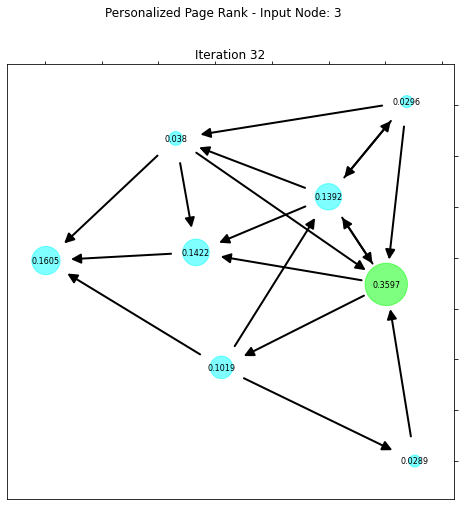

In [10]:
input_node = 3

f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)
ani = FuncAnimation(
    f,
    update,
    frames=personalized_pagerank(G, input_node),
    interval=700,
    blit=False
)
f.suptitle(f'Personalized Page Rank - Input Node: {input_node}')
ani.save('personalized_pagerank.gif')

### References:

https://github.com/networkx/networkx/blob/main/networkx/algorithms/link_analysis/pagerank_alg.py
<br>
https://towardsdatascience.com/pagerank-algorithm-fully-explained-dc794184b4af
<br>
https://www.youtube.com/watch?v=RVIr8Y5isek
<br>
Visualization:
https://stellasia.github.io/blog/2020-03-07-page-rank-animation-with-networkx-numpy-and-matplotlib/